**Note - Some part of the notebook have been taken from public kaggle kernels and edited as per the requirement**

**Importing Packages**

In [1]:
# Input data files are available in the "../input/" directory.

%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import os
import glob
import h5py
import shutil
import itertools


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


color = sns.color_palette()

print(os.listdir("../input/"))

Using TensorFlow backend.


['data', 'chest-xray-pneumonia']


**Reading all the data and retrieving classes for which we have more than 1000 images. Then selecting images with clases mentioned in the list - diseases below and creating a dataframe from those images**

In [2]:
df = pd.read_csv('../input/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in glob(
    os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(all_image_paths.get)
df = df[['Image Index', 'Finding Labels','path']]
for d in df['Finding Labels'].unique():
    temp = df[df['Finding Labels'] == d]
    if(len(temp)>=1000):
        print(d,len(temp))
        
diseases = [ 'No Finding', 'Mass', 'Nodule']

df = df[df['Finding Labels'].isin(diseases)]


df1=pd.DataFrame()
for d in df['Finding Labels'].unique():
    temp = df[df['Finding Labels'] == d].reset_index()
    del temp['index']
    if (d == 'No Finding'):
        temp = temp[0:2000]
    else:
        temp = temp[0:2000]
    df1 = df1.append(temp)

df1.head()

Cardiomegaly 1093
No Finding 60361
Infiltration 9547
Effusion|Infiltration 1603
Nodule 2705
Effusion 3955
Atelectasis 4215
Pleural_Thickening 1126
Pneumothorax 2194
Mass 2139
Consolidation 1310
Atelectasis|Infiltration 1350
Atelectasis|Effusion 1165


Image Index                        ...                                                                     path
0  00000002_000.png                        ...                         ../input/data/images_001/images/00000002_000.png
1  00000005_000.png                        ...                         ../input/data/images_001/images/00000005_000.png
2  00000005_001.png                        ...                         ../input/data/images_001/images/00000005_001.png
3  00000005_002.png                        ...                         ../input/data/images_001/images/00000005_002.png
4  00000005_003.png                        ...                         ../input/data/images_001/images/00000005_003.png

[5 rows x 3 columns]

**Assigning numerical class value to the diffrent diseases**

In [3]:
label = df1['Finding Labels'].unique()
dic = {}
dic['No Finding'] = 0
i=1
for l in label:
    if(l == 'No Finding'):
        continue
    dic[l] = i
    i+=1
print(dic)
df1['label'] = df1['Finding Labels'].map(dic)
df1.head()

{'No Finding': 0, 'Nodule': 1, 'Mass': 2}


Image Index  ...  label
0  00000002_000.png  ...      0
1  00000005_000.png  ...      0
2  00000005_001.png  ...      0
3  00000005_002.png  ...      0
4  00000005_003.png  ...      0

[5 rows x 4 columns]

**Adding pneumonia images to our existing prepared dataframe from different data-source**

In [4]:
# Define path to the data directory
data_dir = '../input/chest-xray-pneumonia/data/data'

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir + '/' + 'train'
t = glob(train_dir + '/pneumonia/*')
t = t[0:2000]

for i in t:
    df_pn = pd.DataFrame(columns=['Image Index', 'Finding Labels', 'path', 'label'])
    df_pn.loc[0,'Image Index'] = i.split('/')[-1]
    df_pn.loc[0,'Finding Labels'] = 'Pneumonia'
    df_pn.loc[0,'path'] = i
    df_pn.loc[0,'label'] = 3
    df1 = df1.append(df_pn)
    
print(df1.tail())

                     Image Index  ...  label
0  person1358_bacteria_3465.jpeg  ...      3
0   person657_bacteria_2549.jpeg  ...      3
0       person376_virus_759.jpeg  ...      3
0   person818_bacteria_2729.jpeg  ...      3
0   person837_bacteria_2753.jpeg  ...      3

[5 rows x 4 columns]


**Sample of each type**

Mass          2000
No Finding    2000
Nodule        2000
Pneumonia     2000
Name: Finding Labels, dtype: int64


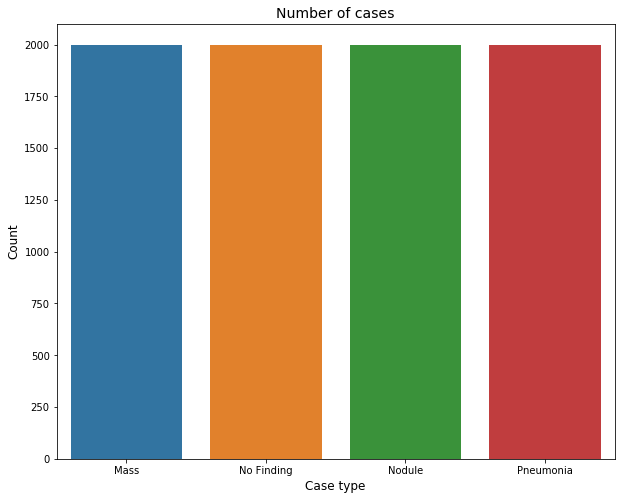

In [7]:
# Get the counts for each class
cases_count = df1['Finding Labels'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

**Preparing train, test and val data**

In [9]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df1, 
                                   test_size = 0.2, 
                                   random_state = 60)


test_df, val_df = train_test_split(valid_df, 
                                   test_size = 0.4, 
                                   random_state = 60)

print('train', train_df.shape[0], 'validation', val_df.shape[0], 'test', test_df.shape[0])

train 6400 validation 640 test 960


In [10]:
train_df['label'].value_counts()

2    1620
0    1604
1    1595
3    1581
Name: label, dtype: int64

**Preparing Train data**

In [12]:
# List that are going to contain validation images data and the corresponding labels
train_data = []
train_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

for i,r in train_df.iterrows():
    img = r['path']
    lab = r['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    train_data.append(img)
    lab = to_categorical(lab, num_classes=4)
    train_label.append(lab)
    


# Convert the list into numpy arrays
train_data = np.array(train_data)
train_label = np.array(train_label)

print("Total number of training examples: ", train_data.shape)
print("Total number of labels:", train_label.shape)

Total number of training examples:  (6400, 224, 224, 3)
Total number of labels: (6400, 4)


**Preparing Validation Data**

In [15]:
# List that are going to contain validation images data and the corresponding labels
val_data = []
val_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

for i,r in val_df.iterrows():
    img = r['path']
    lab = r['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    val_data.append(img)
    lab = to_categorical(lab, num_classes=4)
    val_label.append(lab)
    

# Convert the list into numpy arrays
val_data = np.array(val_data)
val_label = np.array(val_label)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_label.shape)

Total number of validation examples:  (640, 224, 224, 3)
Total number of labels: (640, 4)


**Preparing Test Data**

In [17]:
# List that are going to contain validation images data and the corresponding labels
test_data = []
test_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

for i,r in test_df.iterrows():
    img = r['path']
    lab = r['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    test_data.append(img)
    lab = to_categorical(lab, num_classes=4)
    test_label.append(lab)


# Convert the list into numpy arrays
test_data = np.array(test_data)
test_label = np.array(test_label)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_label.shape)

Total number of test examples:  (960, 224, 224, 3)
Total number of labels: (960, 4)


**Deleting dataframes to free up memory**

In [18]:
del train_df
del val_df
del df
del df1

**Data Generator to Augment Dataset**

In [19]:
# This generator will enrich our existing small dataset and provide variation in our data which will help to build robu

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range=12, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,)  # randomly flip images

**Defining Callbacks**

In [20]:
# Callback to prevent overfitting
es = EarlyStopping(patience=5)

# Reduce learning rate on plateau i.e. when there is no/minimal change in evaluation metrics(validation accuracy in my case)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

**VGG 16 Transfer Learning**

In [21]:
from keras.models import Model

def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))
    
    x=model.output

    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    
    #x=Dropout(rate = 0.7, name='dropout2')(x)
    #x=Dense(1024,activation='relu')(x)
    #x=Dropout(rate = 0.7, name='dropout3')(x)
    
    preds=Dense(num_classes,activation='softmax')(x)
    
    model=Model(inputs=model.input,outputs=preds)

    #To set the first 1 layers to non-trainable (weights will not be updated)
    for layer in model.layers[0:1]:
        layer.trainable = False

    # Defining optimizers
    adm = Adam(lr=0.0001)
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:
img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 4

# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 0s 0us/step


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Model Training**

In [24]:
#Using Data Gen
datagen.fit(train_data)

# Training the model
history_vgg = model.fit_generator(datagen.flow(train_data, train_label, batch_size=64),epochs = 20, 
                                   validation_data = (val_data,val_label),verbose = 1,
                                   steps_per_epoch=train_data.shape[0]//64
                                   , callbacks=[learning_rate_reduction,es],class_weight='auto')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 77s 767ms/step - loss: 0.9959 - acc: 0.4628 - val_loss: 0.8547 - val_acc: 0.4891
Epoch 2/20
100/100 [==============================] - 73s 726ms/step - loss: 0.8445 - acc: 0.5211 - val_loss: 0.8160 - val_acc: 0.5687
Epoch 3/20
100/100 [==============================] - 73s 731ms/step - loss: 0.8105 - acc: 0.5708 - val_loss: 0.7800 - val_acc: 0.6000
Epoch 4/20
100/100 [==============================] - 74s 736ms/step - loss: 0.8005 - acc: 0.5817 - val_loss: 0.7568 - val_acc: 0.6109
Epoch 5/20
100/100 [==============================] - 72s 720ms/step - loss: 0.7549 - acc: 0.6161 - val_loss: 0.7123 - val_acc: 0.6469
Epoch 6/20
100/100 [==============================] - 72s 719ms/step - loss: 0.7447 - acc: 0.6287 - val_loss: 0.7024 - val_acc: 0.6734
Epoch 7/20
100/100 [==============================] - 71s 706ms/step - loss: 0.7018 - acc: 0.6625 - val_loss: 0.7076 - val_acc: 0.6500
Epoch 8

**Tried a different model-architecture for exploring. therefore commented**

In [25]:
'''def conv_model():
    
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size= (3,3), padding = 'same', activation='relu',input_shape=(224,224,3)))
    model.add(Conv2D(64, kernel_size= (3,3), padding = 'same', activation='relu'))
    #model.add(Conv2D(64, kernel_size= (3,3), padding = 'same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    
    model.add(Conv2D(128, kernel_size= (3,3), activation='relu',padding = 'same'))
    model.add(Conv2D(128, kernel_size= (3,3), padding = 'same', activation='relu'))
    #model.add(Conv2D(128, kernel_size= (3,3), padding = 'same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, kernel_size= (3,3), activation='relu',padding = 'same'))
    model.add(Conv2D(256, kernel_size= (3,3), padding = 'same', activation='relu'))
    #model.add(Conv2D(256, kernel_size= (3,3), padding = 'same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(512, kernel_size= (3,3), activation='relu',padding = 'same'))
    model.add(Conv2D(512, kernel_size= (3,3), padding = 'same', activation='relu'))
    #model.add(Conv2D(512, kernel_size= (3,3), padding = 'same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    
    #model.add(GlobalAveragePooling2D())
    model.add(Dense(4, activation='softmax'))
    #o = optimizers.RMSprop(lr=0.001,rho=0.9, decay = 0.0, epsilon=1e-8)
    adm = Adam(lr=0.0001)
    rms = RMSprop(lr=0.0001,rho=0.9, decay = 0.0, epsilon=1e-8)
    model.compile(loss='categorical_crossentropy', optimizer= adm ,metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer= 'rmsprop' ,metrics=['accuracy'])
    return model'''

"def conv_model():\n    \n    model = Sequential()\n    \n    model.add(Conv2D(64, kernel_size= (3,3), padding = 'same', activation='relu',input_shape=(224,224,3)))\n    model.add(Conv2D(64, kernel_size= (3,3), padding = 'same', activation='relu'))\n    #model.add(Conv2D(64, kernel_size= (3,3), padding = 'same', activation='relu'))\n    model.add(MaxPool2D(pool_size=(2, 2)))\n    model.add(BatchNormalization())\n    model.add(Dropout(0.5))\n\n    \n    model.add(Conv2D(128, kernel_size= (3,3), activation='relu',padding = 'same'))\n    model.add(Conv2D(128, kernel_size= (3,3), padding = 'same', activation='relu'))\n    #model.add(Conv2D(128, kernel_size= (3,3), padding = 'same', activation='relu'))\n    model.add(MaxPool2D(pool_size=(2,2)))\n    model.add(BatchNormalization())\n    model.add(Dropout(0.5))\n    \n    model.add(Conv2D(256, kernel_size= (3,3), activation='relu',padding = 'same'))\n    model.add(Conv2D(256, kernel_size= (3,3), padding = 'same', activation='relu'))\n    #mod

**Loss and Accuracy Graph over epochs**

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


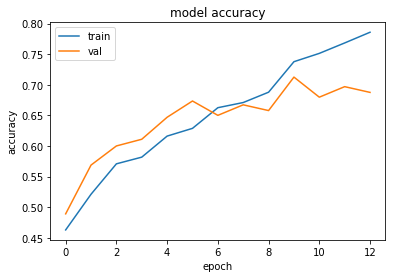

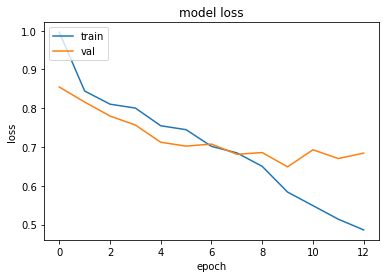

In [28]:
# list all data in history
print(history_vgg.history.keys())

# summarize history for accuracy
plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Confusion matrix**

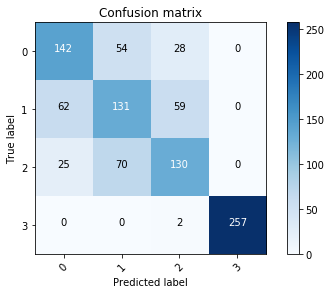

In [29]:
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(test_data)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_label, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

**Save model**

In [30]:
'''# serialize model to JSON
model_json = model.to_json()
with open("file_name.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("file_name.h5")
print("Saved model to disk")'''

Saved model to disk


**Reading sample test image**

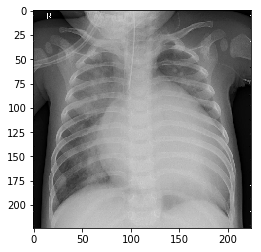

(1, 224, 224, 3)


In [31]:
from keras.preprocessing import image

img_path = '../input/chest-xray-pneumonia/data/data/train/pneumonia/file_name.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

**Predicting Class**

In [32]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=64)
classes = classes.argmax(axis=-1)
print("Predicted class is:",classes)

Predicted class is: [3]


**Visualizing Activations of Intermediate layers**

In [33]:
from keras import models

# Extracts the outputs of selected layers
layer_outputs = [layer.output for layer in model.layers[1:15]]

# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

**Displaying activations at each layer.
The first layer is retaining the full shape, although there are some filters that are not yet activated and are left blank. At this stage, the activations retains almost all of the information in the initial picture. As we go deeper into the layers, the activations become abstract and less visually interpretable. They begin to encode higher-level concepts such as single borders, corners and angles. Higher representations carry less information about the visual contents of the image, and more information related to the class of the image.**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


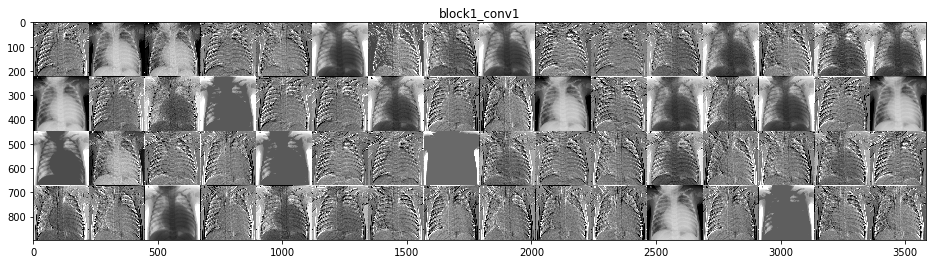

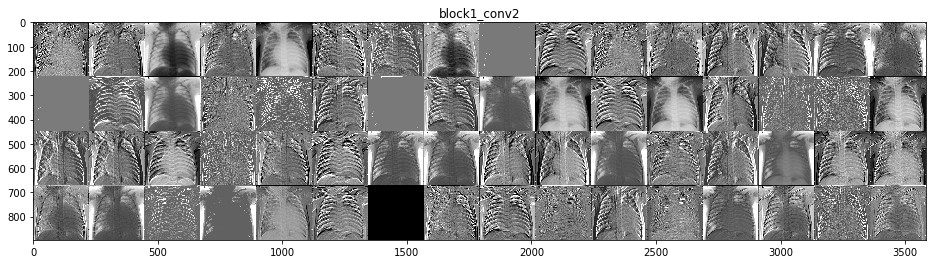

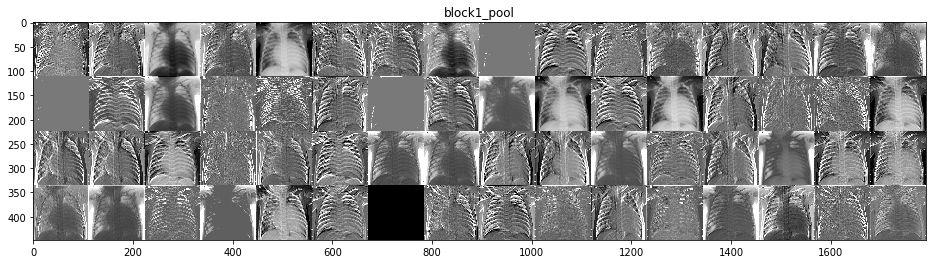

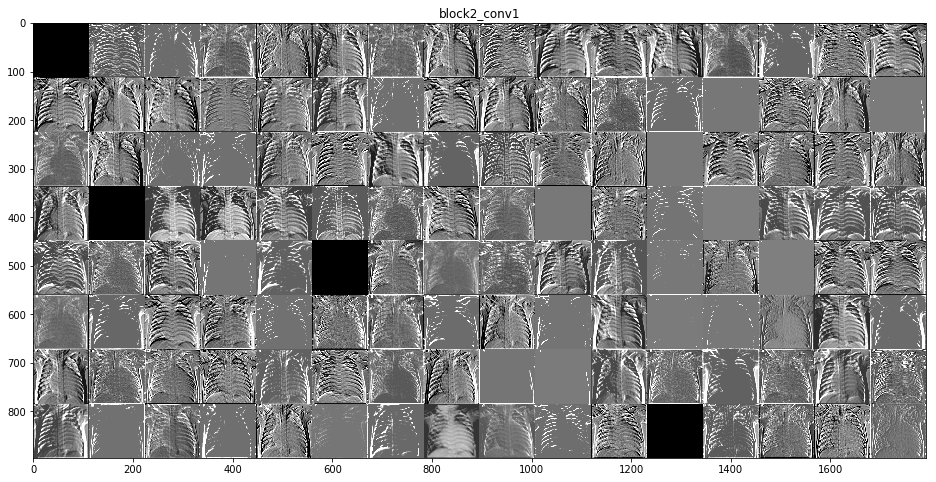

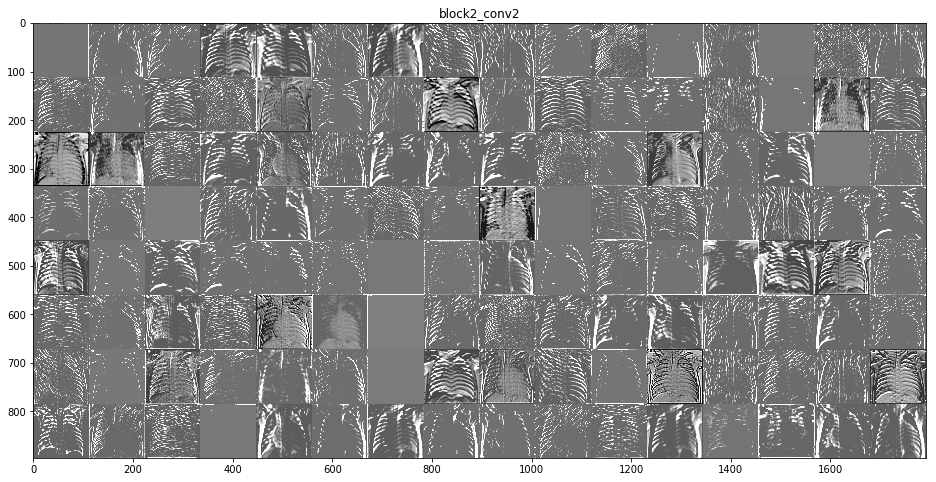

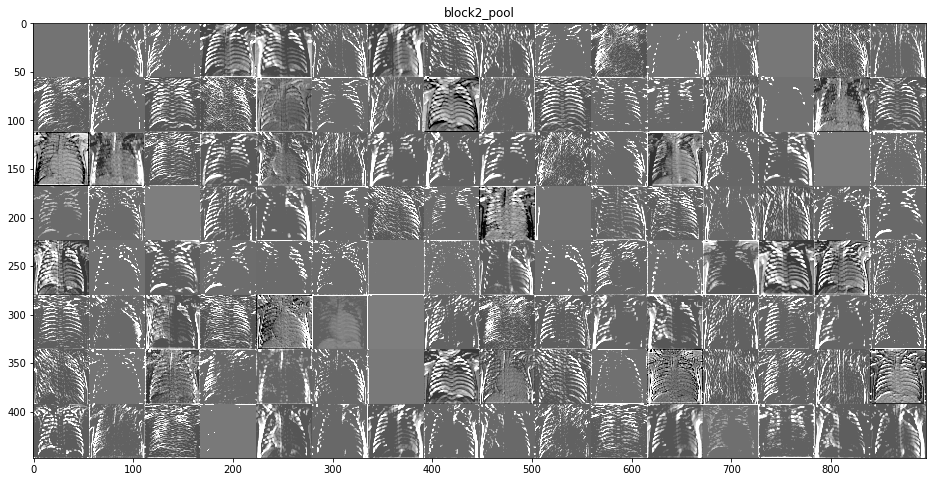

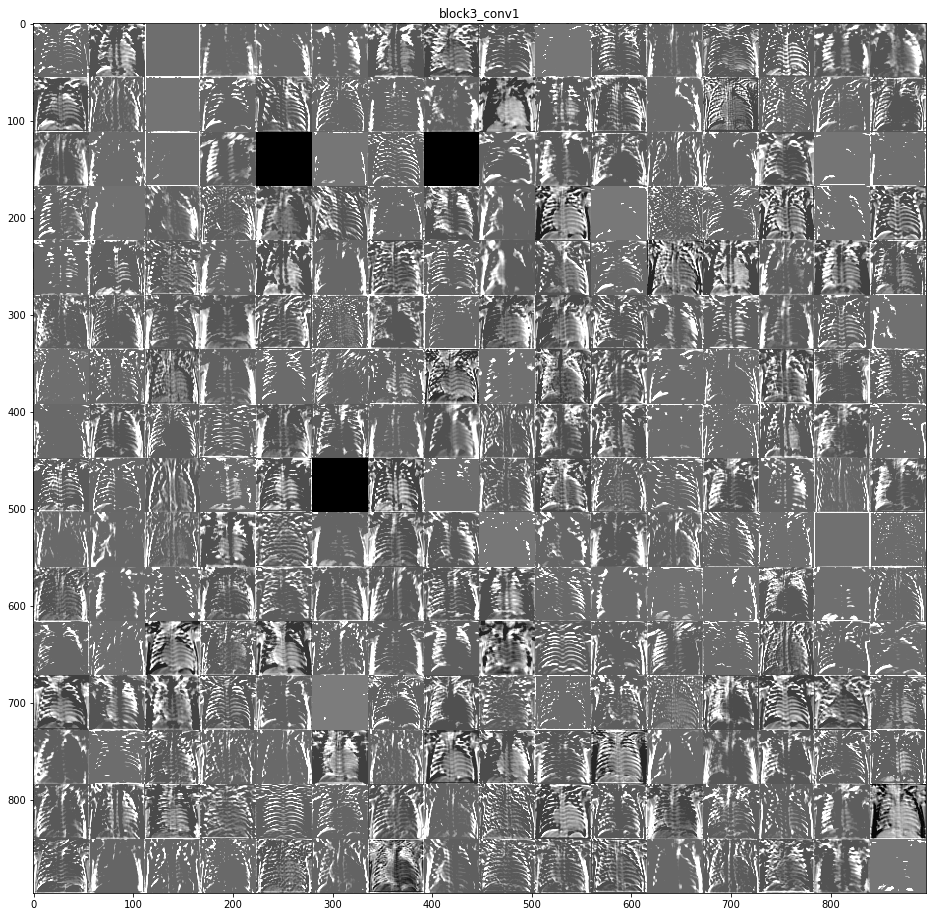

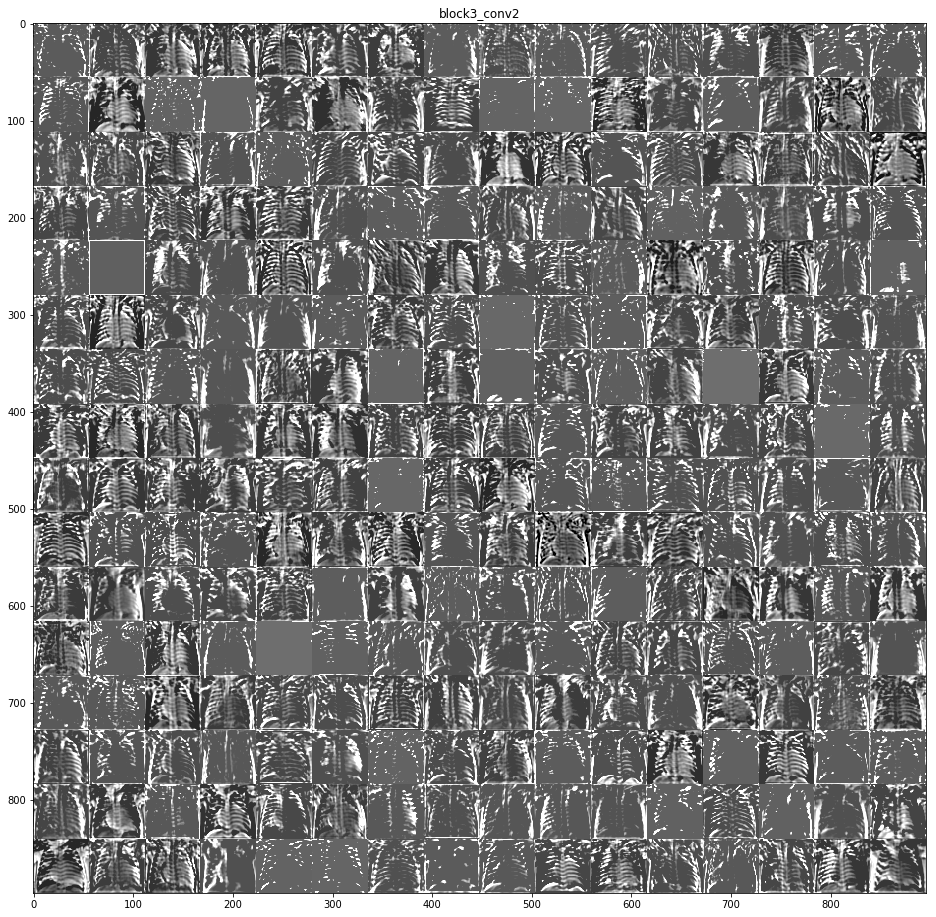

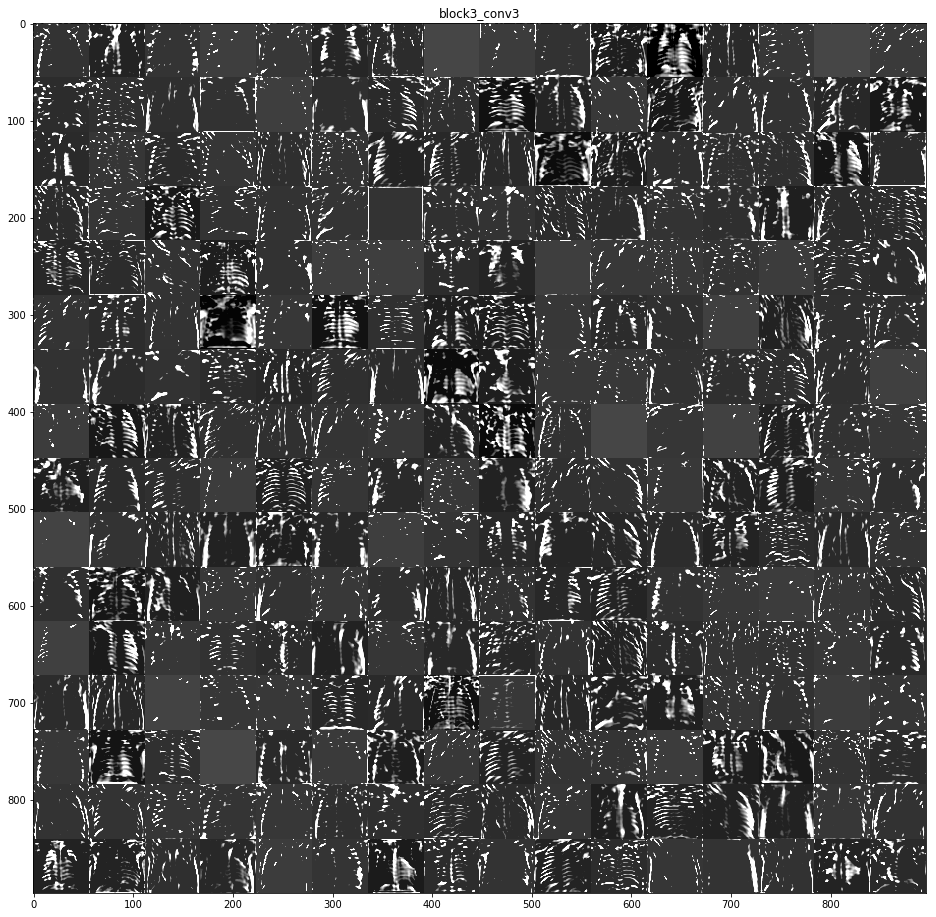

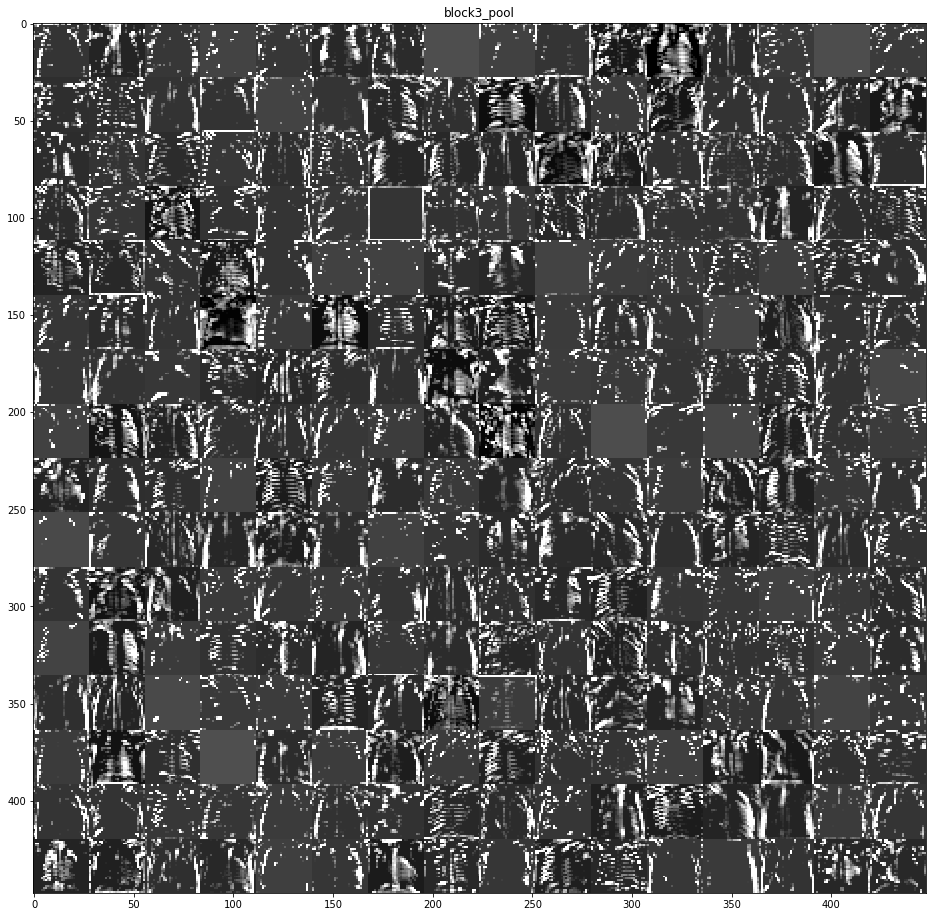

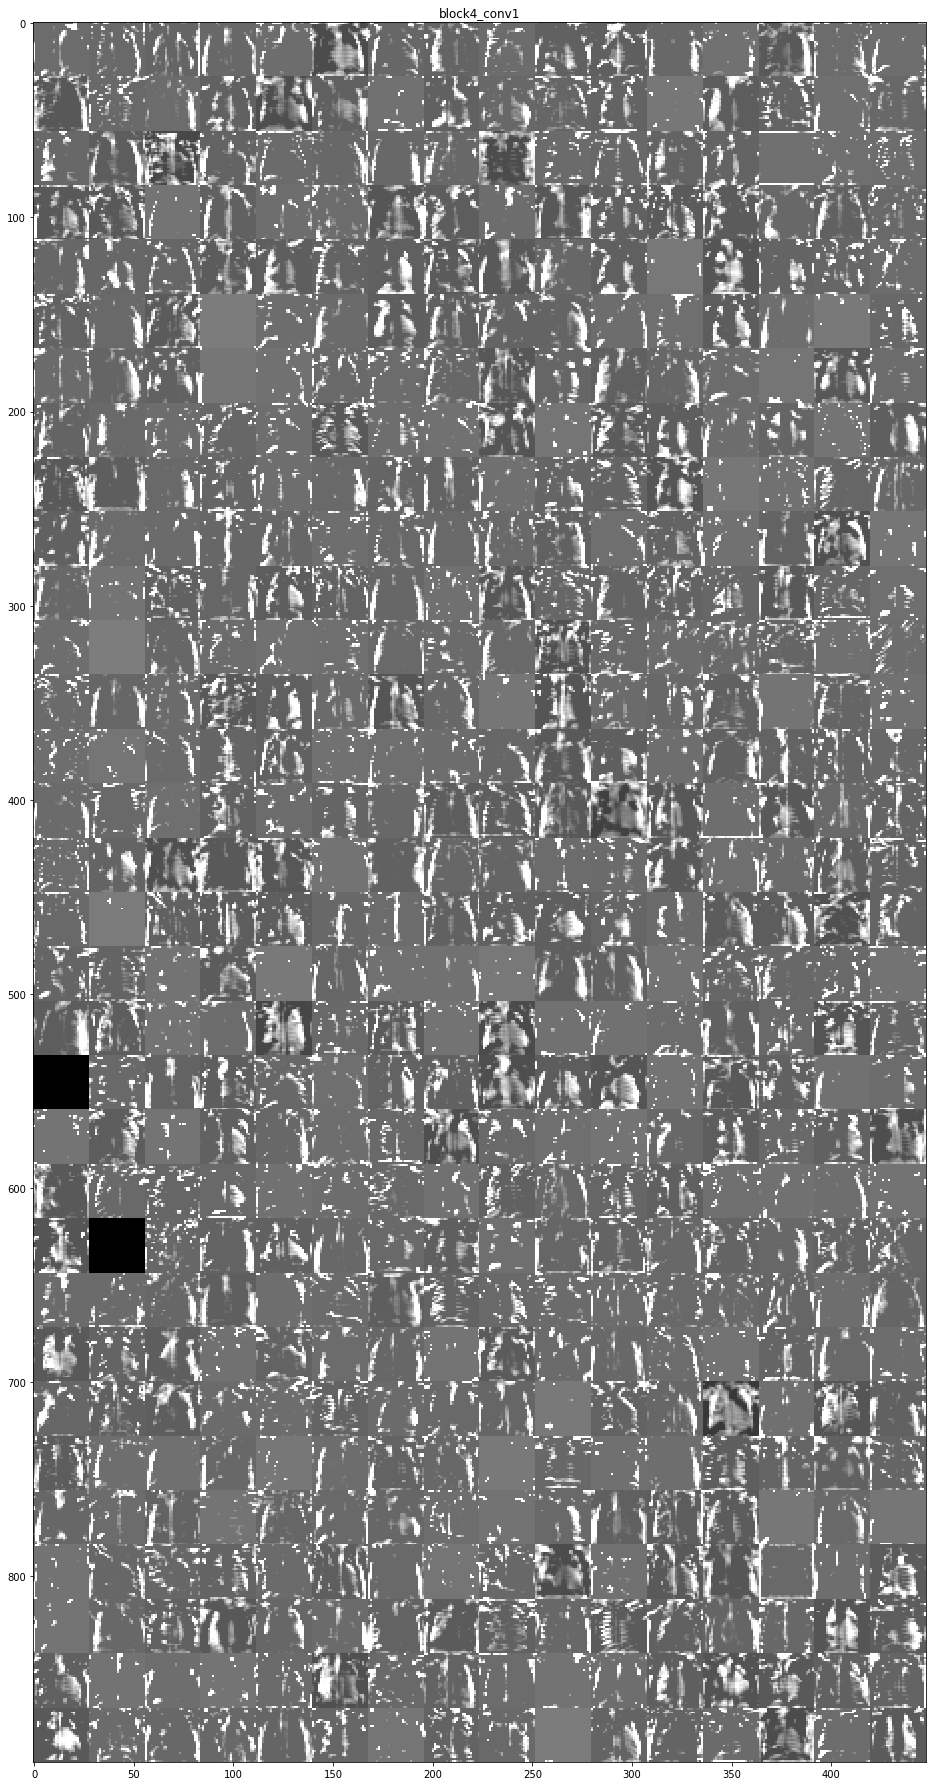

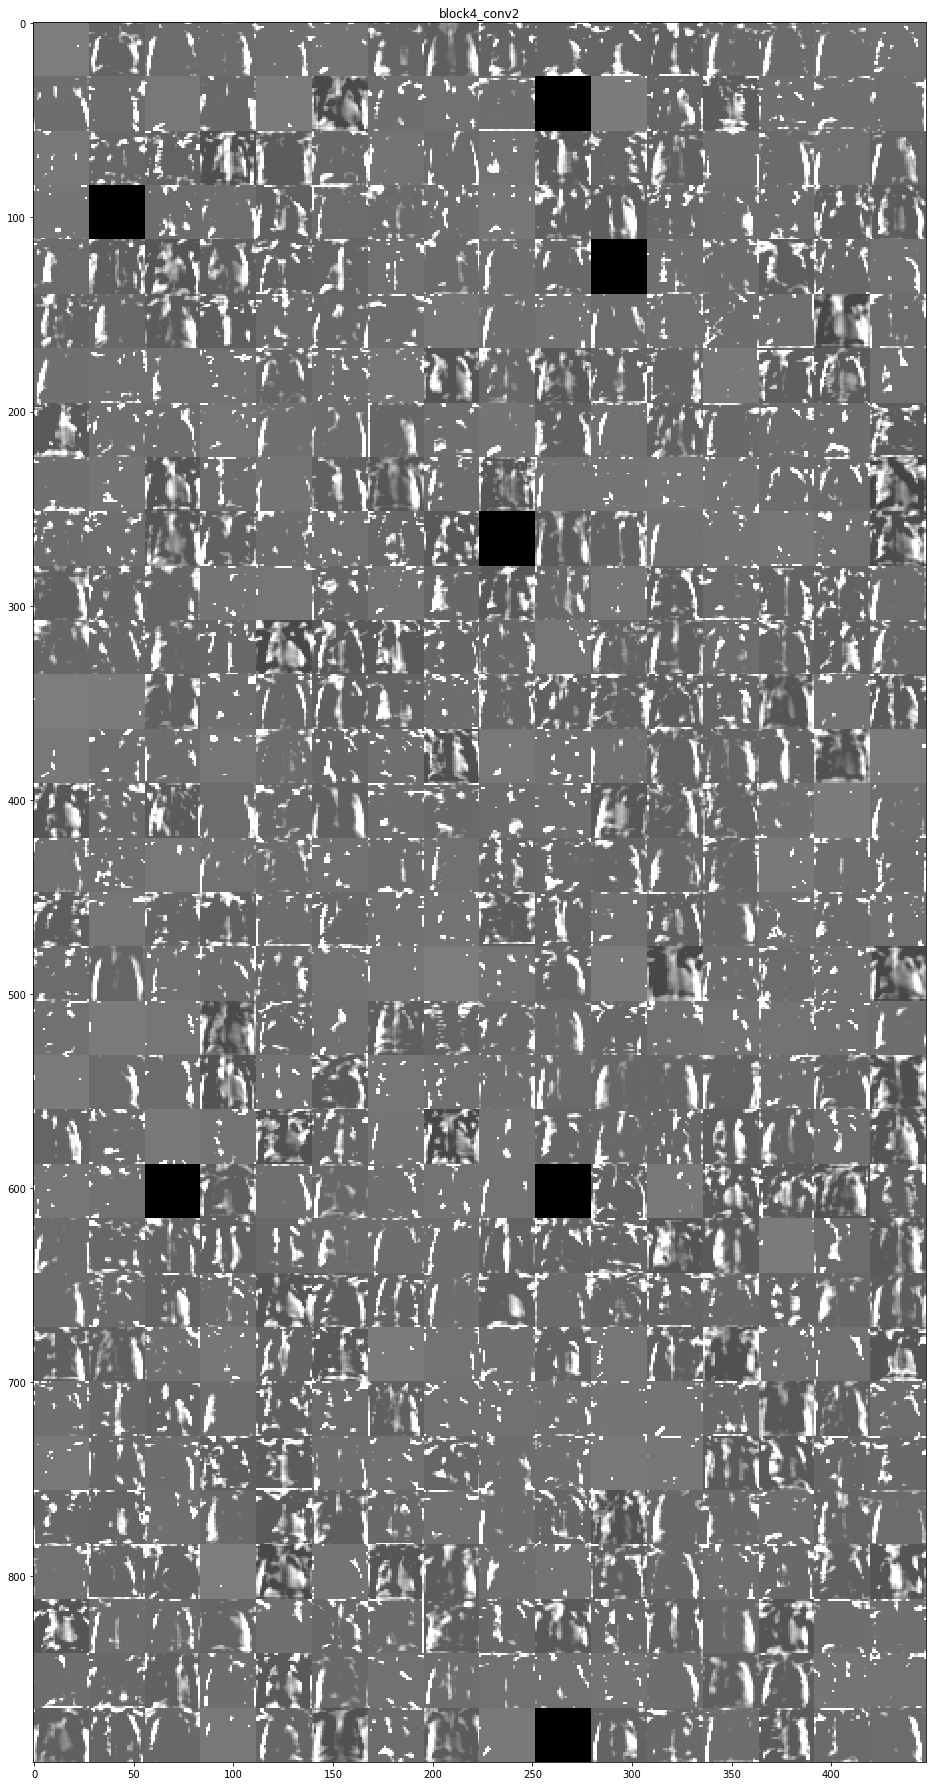

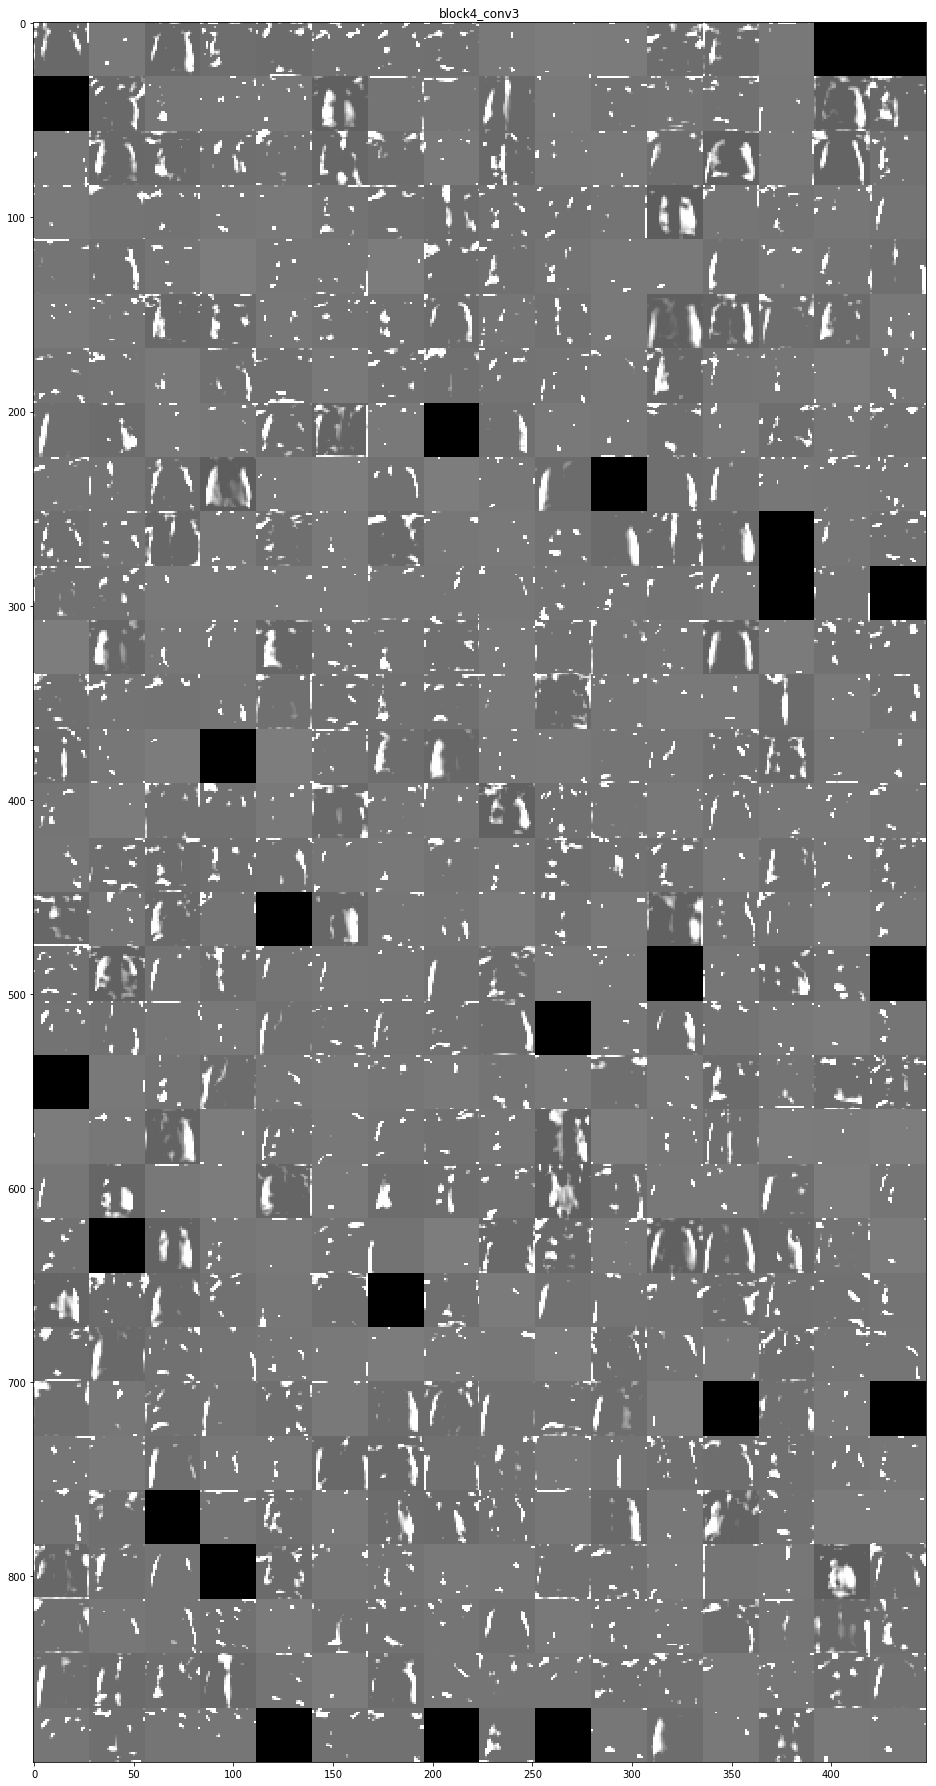

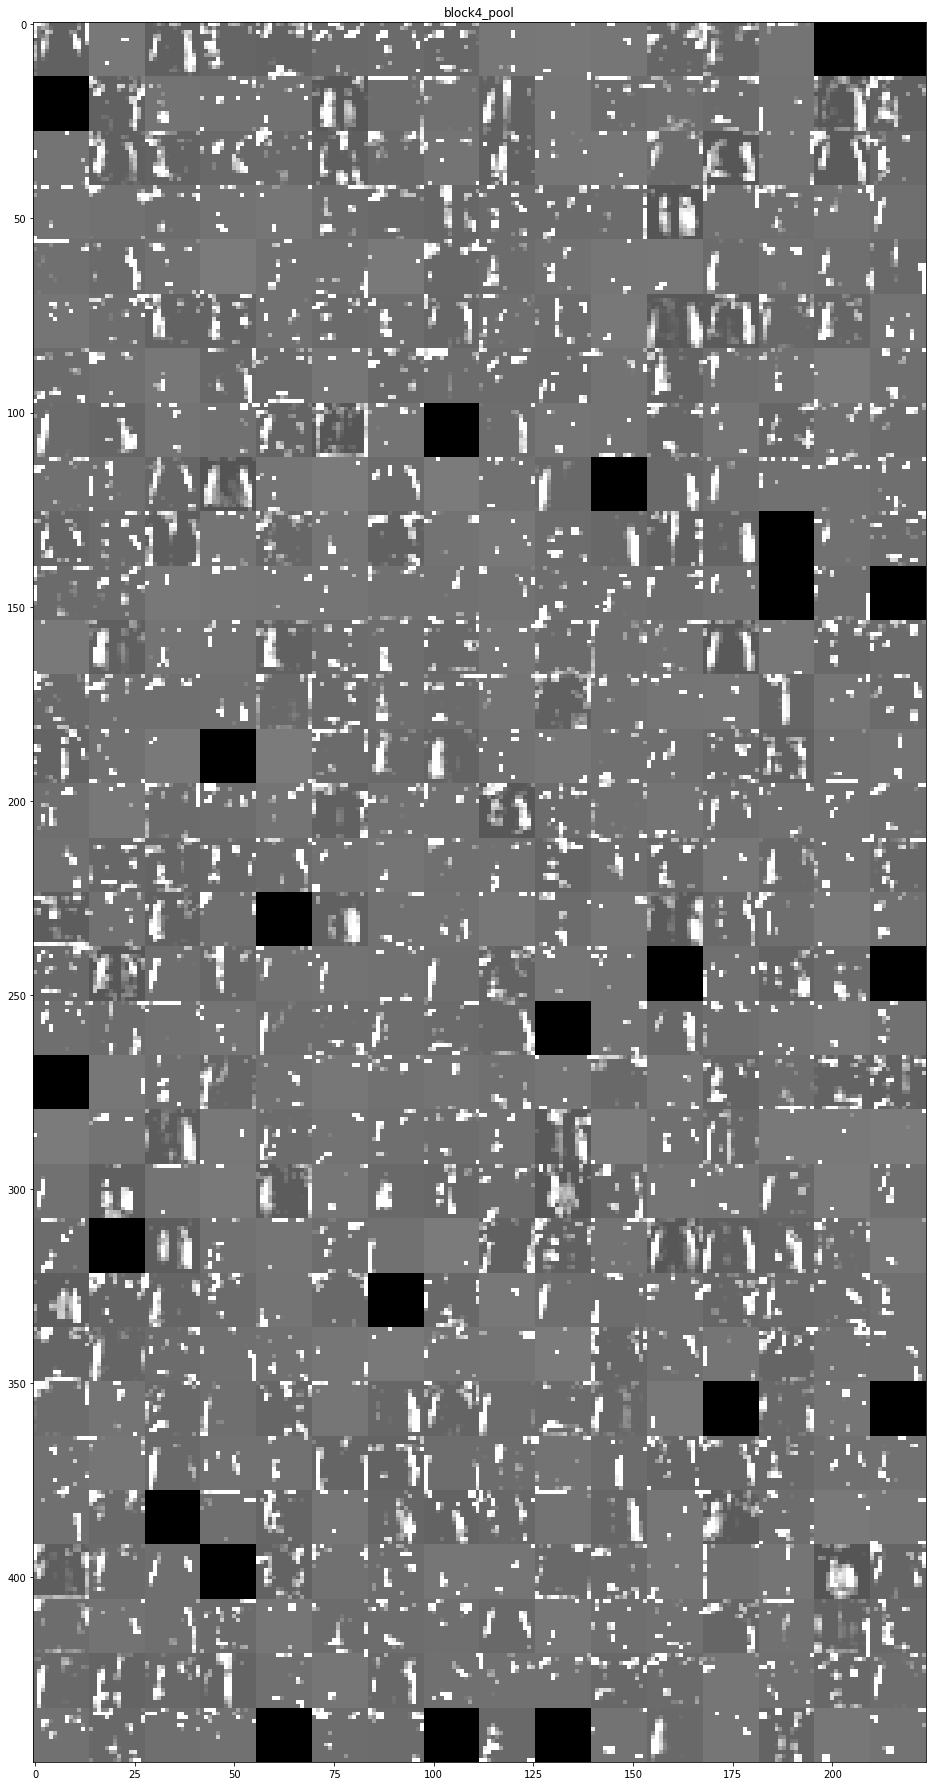

In [36]:
layer_names = []
for layer in model.layers[1:15]:
    layer_names.append(layer.name) 
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

**Creating the class activation map. Class activation maps tells us which part of the image was most dominant is predicting the output class. Red denotes for high dominating part while blue denotes least involving part**

(7, 7, 512)


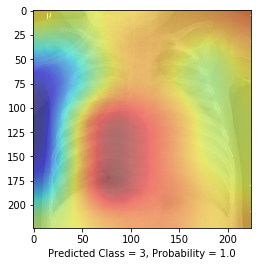

In [37]:
import scipy as sp

# get the weights from the last layer
gap_weights = model.layers[-1].get_weights()[0]

# create a new model to output the feature maps and the predicted labels
cam_model = Model(inputs=model.input, outputs=(model.layers[-4].output, model.layers[-1].output)) 

# make the prediction for a set of test images
features, results = cam_model.predict(img_tensor)

# check the prediction test image
# get the feature map of the test image
features_for_one_img = features[0,:,:,:]

print(features_for_one_img.shape)

# map the feature map to the original size
height_roomout = 224 / features_for_one_img.shape[0]
width_roomout = 224 / features_for_one_img.shape[1]
cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=3)

# get the predicted label with the maximum probability
pred = np.argmax(results[0])

# prepare the final display
plt.figure(facecolor='white')

# get the weights of class activation map
cam_weights = gap_weights[:, pred]

# create the class activation map
cam_output = np.dot(cam_features, cam_weights)

# draw the class activation map
buf = 'Predicted Class = ' + str(pred) + ', Probability = ' + str(results[0][pred])
plt.xlabel(buf)
plt.imshow(img_tensor[0], alpha=0.5)
plt.imshow(cam_output, cmap='jet', alpha=0.5)

plt.show()